In [72]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [73]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [74]:
# vocab_size = 5000
embedding_dim = 200
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [75]:
articles = []
labels = []

with open("clean_uza_mini.csv", 'r', encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[1])        
        articles.append(row[2])
print(len(labels))
print(labels[0])
print(len(articles))
print(articles[0])

1000
world
1000
ўзбекистон  ҳиндистон ҳамкорлик уфқи кенгаймоқда  ҳиндистон инфратузилмани ривожлантириш учун ўзбекистонга  миллиард доллар имтиёзли кредит ажратади  мазкур таклифни мамлакатнинг ўзбекистондаги фавқулодда ва мухтор элчиси шри сантош жа билдирди   ўзбекистон билан ҳамкорлигимизнинг муҳим йўналишларидан бири  инфратузилмани ривожлантириш борасидаги алоқаларни янада кенгайтиришга интиламиз  деди элчи ҳиндистон миллий байрами  республика кунига бағишлаб ўтказилган маросимда  айни мақсадларни амалга ошириш учун ҳиндистон ўзбекистонга  миллиард доллар миқдорида имтиёзли кредит таклиф этади ушбу маблағнинг бир қисми   миллион доллар ажратилиши тўғрисидаги келишув  йил январида кучга кирган  ҳиндистон томони мамлакатимизни ривожлантиришга қаратилган лойиҳаларни қўллабқувватлаш учун грант кўринишида ёрдам ажратиш ниятини ҳам билдирган ҳозирги пайтда ўзбекистон тараққиётининг устувор йўналишлари сифатида белгиланган қатор соҳаларга тегишли лойиҳалар кўриб чиқиляпти   янгиланишлар

In [76]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(articles)

word_index = tokenizer.word_index
vocab_size=len(word_index)

print(vocab_size)

42788


In [77]:
sequences = tokenizer.texts_to_sequences(articles)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_size = int(len(articles) * training_portion)
training_sequences = padded[0:train_size]
train_labels = labels[0:train_size]

validation_sequences = padded[train_size:]
validation_labels = labels[train_size:]

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [78]:
print(training_sequences.shape)
print(validation_sequences.shape)
print(training_label_seq.shape)
print(validation_label_seq.shape)

(800, 300)
(200, 300)
(800, 1)
(200, 1)


In [79]:
print(vocab_size)
print(word_index['сўз'])

42788
156


In [80]:
from gensim.models import Word2Vec
model = Word2Vec.load("mini_word2vec.model")
print(len(model.wv.vocab))
print(len(model.wv['сўз']))

7173
200


In [81]:
import numpy as np

embeddings_index = {};


embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    if word in model.wv.vocab:
        embeddings_matrix[i] = model.wv[word]
    else:
        embeddings_matrix[i] = [0]*200;

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 200)          8557800   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300, 200)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 296, 64)           64064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 8,655,278
Trainable params: 97,478
Non-trainable params: 8,557,800
_______________________________________

In [83]:
num_epochs = 20
history = model.fit(training_sequences, training_label_seq, epochs=num_epochs, validation_data=(validation_sequences, validation_label_seq), verbose=2)

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 - 6s - loss: 1.6068 - accuracy: 0.3787 - val_loss: 1.3647 - val_accuracy: 0.5350
Epoch 2/20
800/800 - 4s - loss: 1.2500 - accuracy: 0.4625 - val_loss: 1.0229 - val_accuracy: 0.5350
Epoch 3/20
800/800 - 4s - loss: 0.9207 - accuracy: 0.6263 - val_loss: 0.9036 - val_accuracy: 0.6550
Epoch 4/20
800/800 - 4s - loss: 0.6039 - accuracy: 0.7887 - val_loss: 0.6031 - val_accuracy: 0.8150
Epoch 5/20
800/800 - 4s - loss: 0.5311 - accuracy: 0.8300 - val_loss: 0.5765 - val_accuracy: 0.7950
Epoch 6/20
800/800 - 4s - loss: 0.4853 - accuracy: 0.8238 - val_loss: 0.5055 - val_accuracy: 0.8000
Epoch 7/20
800/800 - 4s - loss: 0.4268 - accuracy: 0.8587 - val_loss: 0.4560 - val_accuracy: 0.8450
Epoch 8/20
800/800 - 4s - loss: 0.3521 - accuracy: 0.8963 - val_loss: 0.3764 - val_accuracy: 0.8800
Epoch 9/20
800/800 - 4s - loss: 0.3515 - accuracy: 0.8900 - val_loss: 0.4555 - val_accuracy: 0.8700
Epoch 10/20
800/800 - 4s - loss: 0.3170 - accuracy: 0.

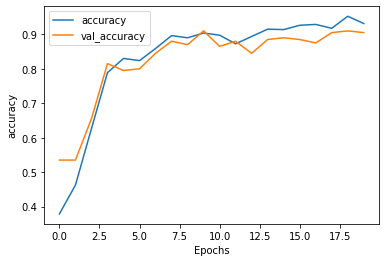

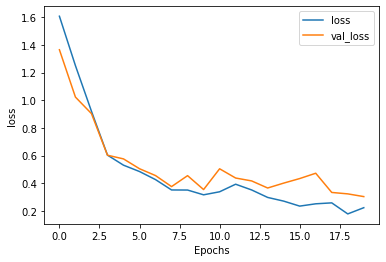

In [84]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss");